In [73]:
import os 
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader 
import pathlib
import glob
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch import flatten
import copy

In [74]:
from google.colab import files

In [75]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/nature_12K.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/nature') #Extracts the files into the /nature folder
zip_ref.close()


### Loading cuda



In [78]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:


from torch.utils.data.sampler import SubsetRandomSampler

# how many samples per batch to load
batch_size =128
# percentage of training set to use as validation
valid_size = 0.2

#To unzip dataset in colab
data_dir='/nature/inaturalist_12K'

train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.RandomResizedCrop(size=(224,224)),
                                       #transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomAffine(degrees=0,scale=(0.3,1)),
                                       transforms.ToTensor(),
                                       
                                       transforms.Normalize([0.5,0.5, 0.5],
                                                            [0.5,0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                      # transforms.RandomResizedCrop(224),
                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,0.5,0.5],
                                                           [0.5,0.5,0.5])])

# Pass transforms in here,
train_data = torchvision.datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = torchvision.datasets.ImageFolder(data_dir + '/val', transform=test_transforms)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]   ################<-------------------

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
print(len(train_sampler))
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler,num_workers=2)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=2)
### below will return total of batches of  data 
train_step=len(train_loader) ### this will return total of batches of  data in (train_sampler//batch_size=(8000/128=63))
val_step=len(valid_loader)
print(train_step,val_step)
test_step=len(test_loader)

8000
63 16


In [7]:
# transformer=transforms.Compose([transforms.Resize((150,150)),transforms.RandomHorizontalFlip(),transforms.RandomRotation((-90,90)),transforms.RandomAffine(degrees=0,scale=(0.3,0.3)),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
                            


In [8]:
# batch=256
# #dataloader
train_path='/nature/inaturalist_12K/train'
test_path='/nature/inaturalist_12K/val'
# train_loader=DataLoader(torchvision.datasets.ImageFolder(train_path,transform=transformer),
#                         batch_size=batch,shuffle=True)
# test_loader=DataLoader(torchvision.datasets.ImageFolder(test_path,transform=transformer),
#                         batch_size=batch,shuffle=True)


In [9]:
print(len(train_loader))

63


In [10]:
# # X,Y=train_loader[0]
# dataiter = iter(train_loader)
# images, labels = dataiter.next() 
# print(labels[0])

In [71]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [12]:
classes=(classes[1:])

In [13]:
print(classes)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [14]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
train_count=int(train_count-train_count*0.2)  #################<----------------
test_count=len(glob.glob(test_path+'/**/*.jpg'))
val_count=int(train_count*0.2)

In [15]:
print(train_count,test_count)

7999 2000


In [16]:
# K=32
# S=3
# batch_norm=True
# activation='Relu'
# nodes=512
class ConvNet(nn.Module):
  def __init__(self,K,S,factor,activation,batch_norm,drop_out,nodes,num_class=10):
    
    super(ConvNet,self).__init__()
    
    self.batch_norm=batch_norm
    
    self.conv1=nn.Conv2d(in_channels=3,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,200,200)
    
    if self.batch_norm=='Yes':
      self.bn1=nn.BatchNorm2d(K)
      
    if activation=='Relu':
      
      self.activ1=nn.ReLU()
    elif activation=='Gelu':
    
      self.activ1=nn.GELU()
    elif activation=='Silu':
      
      self.activ1=nn.SiLU()
    elif activation=='Mish':
      
      self.activ1=nn.Mish()
      
    self.maxpool1=nn.MaxPool2d(kernel_size=2)## shape=(256,K,100,100)
    
    K_prev=K
    K=int(K*factor)
    #layer 2
    self.conv2=nn.Conv2d(in_channels=K_prev,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,100,100)
    if self.batch_norm=='Yes':
      self.bn2=nn.BatchNorm2d(K)
    if activation=='Relu':
      self.activ2=nn.ReLU()
    elif activation=='Gelu':
      self.activ2=nn.GELU()
    elif activation=='Silu':
      self.activ2=nn.SiLU()
    elif activation=='Mish':
      self.activ2=nn.Mish()
    self.maxpool2=nn.MaxPool2d(kernel_size=2)
    ##shape=(256,K,50,50)
    K_prev=K
    K=int(K*factor)
    # layer 3
    self.conv3=nn.Conv2d(in_channels=K_prev,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,50,50)
    if self.batch_norm=='Yes':
      self.bn3=nn.BatchNorm2d(K)
    if activation=='Relu':
      self.activ3=nn.ReLU()
    elif activation=='Gelu':
      self.activ3=nn.GELU()
    elif activation=='Silu':
      self.activ3=nn.SiLU()
    elif activation=='Mish':
      self.activ3=nn.Mish()
    self.maxpool3=nn.MaxPool2d(kernel_size=2)
    ##shape=(256,K,25,25)
    K_prev=K
    K=int(K*factor)
    #layer 4
    self.conv4=nn.Conv2d(in_channels=K_prev,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,25,25)
    if self.batch_norm=='Yes':
      self.bn4=nn.BatchNorm2d(K)
    if activation=='Relu':
      self.activ4=nn.ReLU()
    elif activation=='Gelu':
      self.activ4=nn.GELU()
    elif activation=='Silu':
      self.activ4=nn.SiLU()
    elif activation=='Mish':
      self.activ4=nn.Mish()
    self.maxpool4=nn.MaxPool2d(kernel_size=2)
    ## shape=(256,K,12,12)
    K_prev=K
    K=int(K*factor)
    #layer 5
    self.conv5=nn.Conv2d(in_channels=K_prev,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,12,12)
    if self.batch_norm=='Yes':
      self.bn5=nn.BatchNorm2d(K)
    if activation=='Relu':
      self.activ5=nn.ReLU()
    elif activation=='Gelu':
      self.activ5=nn.GELU()
    elif activation=='Silu':
      self.activ5=nn.SiLU()
    elif activation=='Mish':
      self.activ5=nn.Mish()
    self.maxpool5=nn.MaxPool2d(kernel_size=2)
    ## shape(256,K,6,6)
    #print(len(self.maxpool5))
     ## shape(256,K,)
    ## FC layer
    # self.dropout1=nn.Dropout(drop_out)            ### ADD DROPOUT HERE
    #print("D:",self.dropout1.shape)
    self.fc1=nn.Linear(in_features=7*7*K,out_features=nodes)
    self.dropout2=nn.Dropout(drop_out)   ### ADD DROP OUT HERE
    self.fc2=nn.Linear(in_features=nodes,out_features=10)
    
    ##feed forward

  def forward(self,x):
    
    out=self.conv1(x)
    if self.batch_norm=='Yes':
      out=self.bn1(out)
    out=self.activ1(out)
    out=self.maxpool1(out)

    out=self.conv2(out)
    if self.batch_norm=='Yes':
      out=self.bn2(out)
    out=self.activ2(out)
    out=self.maxpool2(out)

    out=self.conv3(out)
    if self.batch_norm=='Yes':
      out=self.bn3(out)
    out=self.activ3(out)
    out=self.maxpool3(out)

    out=self.conv4(out)
    if self.batch_norm=='Yes':
      out=self.bn4(out)
    out=self.activ4(out)
    out=self.maxpool4(out)
    
    out=self.conv5(out)
    if self.batch_norm=='Yes':
      out=self.bn5(out)
    out=self.activ5(out)
    out=self.maxpool5(out)
    
    # out=self.dropout1(out)
    b,c,d,e=out.shape
  
    out=out.view(-1,d*e*c)  
    
    out=F.relu(self.fc1(out))
    out=self.dropout2(out)
    out=F.relu(self.fc2(out))
    out=F.softmax(out,dim=1)
    
    return out


# K,S,factor,activation,batch_norm,drop_out,nodes=64,3,1,'Gelu','No',0.3,256
# net=ConvNet(K,S,factor,activation,batch_norm,drop_out,nodes,num_class=10)
# print(net)

In [17]:
# model=ConvNet(K,S,factor,activation,batch_norm,drop_out,nodes,num_class=10).to(device)

In [18]:
# import torch.optim as optim

# optimizer=optim.Adam(model.parameters(),lr=0.0002)
# loss_fun=nn.CrossEntropyLoss()



In [19]:
# from torch.autograd import Variable
# ##model training

# best_accuracy=0

# for epoch in range(30):

#   model.train()
#   train_accuracy=0.0
#   train_loss=0.0
#   for i,(images,labels) in enumerate(train_loader):
    
    
#     images=images.to(device)
#     labels=labels.to(device)
    
#     optimizer.zero_grad()
    
#     outputs=model(images)
#     loss=loss_fun(outputs,labels)
#     # print(loss.dtype)
#     #print(loss)
#     loss.backward()
#     optimizer.step()
#     #print(loss.cpu().data)
#     train_loss+=(loss.item())/batch_size
#     #print(loss.item())
#     _,prediction=torch.max(outputs.data,1)
    
#     train_accuracy+=int(torch.sum(prediction==labels.data))
#   train_accuracy=(train_accuracy/(batch_size*train_step))*100
#   train_loss=(train_loss/train_step)*100
#   print(train_loss)

#   ##evalution on testing data
#   model.eval()
#   with torch.no_grad():
#     test_accuracy=0.0

#     for i,(images,labels) in enumerate(valid_loader):
    
#       images=images.to(device)
#       labels=labels.to(device)
      
#       outputs=model(images)

#       _,prediction=torch.max(outputs.data,1)
#       test_accuracy+=int(torch.sum(prediction==labels.data))
  
#   test_accuracy=(test_accuracy/(batch_size*val_step))*100


#   print('Epoch:'+str(epoch)+' Train Loss:'+str(float(train_loss))+' Train accuracy'+str(train_accuracy)+' valaccuracy'+str(test_accuracy))
  
#   # if test_accuracy>best_accuracy:
#   #   torch.save(model.state_dict(),'best_checkpoint.model')
#   #   best_accuracy=test_accuracy


In [20]:
#  !pip install wandb

In [21]:
# install,login and import wandb

In [22]:
# import wandb

In [23]:
# !wandb login --relogin

In [24]:
# sweep_configuration={'name':'EE22s037','method':'bayes',
#                       'metric':{'name':'val_acc','goal':'maximize'},
#                       'parameters':{#'epoch':{'values':[15,30]},
#                                     # 'lr':{'values':[0.01,0.001,0.0005]},
#                                     'filter_n':{'values':[32,64]},
#                                     # 'filter_size':{'values':[3]},
#                                     'filter_org':{'values':[1,2,0.5]},
#                                     'activation':{'values':['Relu','Gelu','Silu','Mish']},
#                                     'batch_norm':{'values':['Yes','No']},
#                                     'drop_out':{'values':[0.2,0.3]}
#                                     #'neurons':{'values':[128,256,512]}                   
#                                    }
                    
                      
#                       }



# def train():
#   wandb.init()
#   # epoch=wandb.config.epoch
#   #lr=wandb.config.lr
#   K=wandb.config.filter_n
#   #S=wandb.config.filter_size
#   factor=wandb.config.filter_org
#   activation=wandb.config.activation
#   batch_norm=wandb.config.batch_norm
#   drop_out=wandb.config.drop_out
#   #nodes=wandb.config.neurons
#   S=3  ## filter_size
#   run_name="Fn_{}_Fo_{}_acf_{}_bn_{}_Do_{}".format(K,factor,activation,batch_norm,drop_out)
#   print("run_name:",run_name)
  
#   model=ConvNet(K,S,factor,activation,batch_norm,drop_out,nodes=256,num_class=10).to(device)
  
#   optimizer=optim.Adam(model.parameters(),lr=0.0003)
#   loss_fun=nn.CrossEntropyLoss()
#   best_accuracy=0
#   train_Loss=[]
#   train_Acc=[]
#   val_Loss=[]
#   val_Acc=[]
#   for e in range(30):
    
#     model.train()
#     train_accuracy=0.0
#     train_loss=0.0
#     for i,(images,labels) in enumerate(train_loader):
      
      
#       images=images.to(device)
#       labels=labels.to(device)

#       optimizer.zero_grad()
#       outputs=model(images)
      
#       loss=loss_fun(outputs,labels)
      
#     #print(loss)
#       loss.backward()
#       optimizer.step()
#       train_loss+=(loss.item())/batch_size
#     #print(loss.cpu().data)
#       # train_loss+=loss.cpu().data*images.size(0)
#       scores,prediction=torch.max(outputs.data,1)

#       train_accuracy+=int(torch.sum(prediction==labels.data))
#     train_accuracy=(train_accuracy/(train_step*batch_size))*100
#     train_Acc.append(train_accuracy)
#     train_loss=(train_loss/train_step)*100
#     train_Loss.append(train_loss)

#     ##evalution on testing data
#     model.eval()
#     with torch.no_grad():
#       val_accuracy=0.0
#       val_loss=0
#       for i,(images,labels) in enumerate(valid_loader):
#         # if torch.cuda.is_available():
#         images=images.to(device)
#         labels=labels.to(device)
        
#         outputs=model(images)
#         loss=loss_fun(outputs,labels)
#         val_loss+=(loss.item())/batch_size
#         scores,prediction=torch.max(outputs.data,1)
#         val_accuracy+=int(torch.sum(prediction==labels.data))
    
#       val_accuracy=(val_accuracy/(val_step*batch_size))*100
#       val_Acc.append(val_accuracy)
#       val_loss=(val_loss/val_step)*100
#       val_Loss.append(val_loss)
    
#     wandb.log({#'epoch':e,
#                'train_acc':train_accuracy,
#                'train_loss':train_loss,
#                'val_acc': val_accuracy,
#                'val_loss':val_loss       
#               })

#   ### print and ploting loss and accuracy here
#   print("max__train_accuracy:",np.max(train_Acc))
#   print("max__validation_accuracy:",np.max(val_Acc))
#   print("min_train_loss:",np.min(train_Loss))
#   print("min_validation_loss:",np.min(val_Loss))
#   plt.plot(train_Loss, 'r', label="Training loss")
#   plt.plot(val_Loss, 'lime', label="Validation loss")
#   plt.title("Training and Validation Loss vs Number of Epochs", size=15)
#   plt.xlabel("Number of epochs", size=15)
#   plt.ylabel("Loss", size=15)
#   plt.legend()
#   plt.show()

  
#   plt.plot(train_Acc, 'r', label="Training Accuracy")
#   plt.plot(val_Acc ,'lime', label="Validation Accuracy")
#   plt.title("Training and Validation Accuracy vs Number of Epochs", size=15)
#   plt.xlabel("Number of epochs", size=15)
#   plt.ylabel("Accuracy", size=15)
#   plt.legend()
#   plt.show()   
#   wandb.run.name = run_name
#   wandb.run.save()
#   wandb.run.finish()
#     # print('Epoch:'+str(epoch)+'Train Loss:'+str(int(train_loss))+'Train accuracy'+str(train_accuracy)+'Test accuracy'+str(test_accuracy))
  
#     # if test_accuracy>best_accuracy:
#     #   torch.save(model.state_dict(),'best_checkpoint.model')
#     #   best_accuracy=test_accuracy


# sweep_id="7z63jlgr"
# wandb.agent(sweep_id,function=train,entity="amanvb-9213",project='DL-assignment2')
 





  

 


### ***Training the Model on Best Hyperparmeter***

In [25]:
def train_best_model():
  ## Best Hyperparameter
  K=32       ##--->> Number of filter in each layer
  activation='Gelu'
  factor=1          ##----> factor by which you want to increase or decrease filter no. in every layer
  batch_norm='Yes'
  drop_out=0.2      
  S=3  ## filter_size
  num_epoch=40
  model=ConvNet(K,S,factor,activation,batch_norm,drop_out,nodes=256,num_class=10).to(device)
  
  optimizer=optim.Adam(model.parameters(),lr=0.0003)
  loss_fun=nn.CrossEntropyLoss()
  best_accuracy=0
  train_Loss=[]
  train_Acc=[]
  val_Loss=[]
  val_Acc=[]
  for e in range(num_epoch):
    
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    for i,(images,labels) in enumerate(train_loader):
      
      
      images=images.to(device)
      labels=labels.to(device)

      optimizer.zero_grad()
      outputs=model(images)
      
      loss=loss_fun(outputs,labels)
      
    #print(loss)
      loss.backward()
      optimizer.step()
      train_loss+=(loss.item())/batch_size

      scores,prediction=torch.max(outputs.data,1)

      train_accuracy+=int(torch.sum(prediction==labels.data))
    train_accuracy=(train_accuracy/(train_step*batch_size))*100
    train_Acc.append(train_accuracy)
    train_loss=(train_loss/train_step)*100
    train_Loss.append(train_loss)

    ##evalution on testing data
    model.eval()
    with torch.no_grad():
      val_accuracy=0.0
      val_loss=0
      for i,(images,labels) in enumerate(test_loader):
        
        images=images.to(device)
        labels=labels.to(device)
        
        outputs=model(images)
        loss=loss_fun(outputs,labels)
        val_loss+=(loss.item())/batch_size
        scores,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))
    
      val_accuracy=(val_accuracy/(test_step*batch_size))*100
      val_Acc.append(val_accuracy)
      val_loss=(val_loss/test_step)*100
      val_Loss.append(val_loss)
    print('Epoch:'+str(e)+'Train Loss:'+str(int(train_loss))+'Train accuracy'+str(train_accuracy)+'Test accuracy'+str(val_accuracy))
    if val_accuracy>best_accuracy:
      torch.save(model.state_dict(),'best_checkpoint.model')
      model_wts=copy.deepcopy(model.state_dict())
      best_accuracy=val_accuracy
    
  ### print and ploting loss and accuracy here
  print("max__train_accuracy:",np.max(train_Acc),"%")
  print("max__validation_accuracy:",np.max(val_Acc),"%")
  print("min_train_loss:",np.min(train_Loss),"%")
  print("min_validation_loss:",np.min(val_Loss),"%")
  plt.plot(train_Loss, 'r', label="Training loss")
  plt.plot(val_Loss, 'lime', label="Validation loss")
  plt.title("Training and Validation Loss vs Number of Epochs", size=15)
  plt.xlabel("Number of epochs", size=15)
  plt.ylabel("Loss", size=15)
  plt.legend()
  plt.show()

  
  plt.plot(train_Acc, 'r', label="Training Accuracy")
  plt.plot(val_Acc ,'lime', label="Validation Accuracy")
  plt.title("Training and Validation Accuracy vs Number of Epochs", size=15)
  plt.xlabel("Number of epochs", size=15)
  plt.ylabel("Accuracy", size=15)
  plt.legend()
  plt.show() 

  model.load_state_dict(model_wts)

  return model
  
    

Epoch:0Train Loss:1Train accuracy16.778273809523807Test accuracy21.728515625
Epoch:1Train Loss:1Train accuracy21.4905753968254Test accuracy23.095703125
Epoch:2Train Loss:1Train accuracy22.65625Test accuracy22.94921875
Epoch:3Train Loss:1Train accuracy24.293154761904763Test accuracy23.828125
Epoch:4Train Loss:1Train accuracy24.838789682539684Test accuracy25.0
Epoch:5Train Loss:1Train accuracy26.264880952380953Test accuracy24.8046875
Epoch:6Train Loss:1Train accuracy26.860119047619047Test accuracy26.123046875
Epoch:7Train Loss:1Train accuracy29.24107142857143Test accuracy28.41796875
Epoch:8Train Loss:1Train accuracy29.55109126984127Test accuracy26.07421875
Epoch:9Train Loss:1Train accuracy30.02232142857143Test accuracy32.568359375
Epoch:10Train Loss:1Train accuracy31.485615079365083Test accuracy30.37109375
Epoch:11Train Loss:1Train accuracy31.187996031746028Test accuracy30.322265625
Epoch:12Train Loss:1Train accuracy31.41121031746032Test accuracy30.56640625
Epoch:13Train Loss:1Train accu

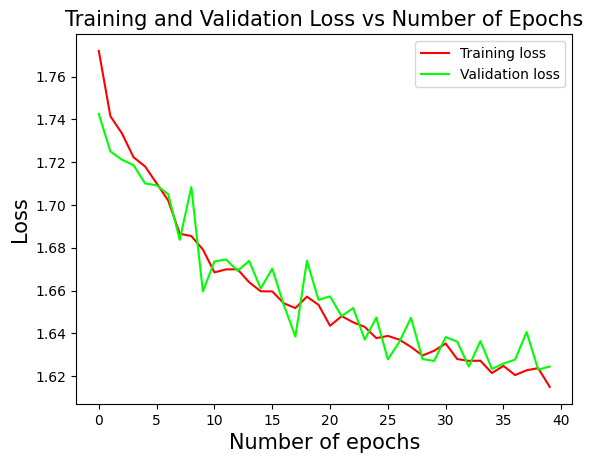

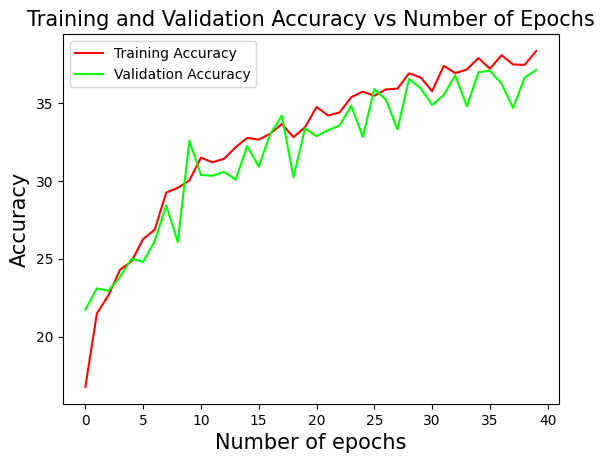

In [26]:
best_model=train_best_model()   

In [47]:
 print(best_model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ1): GELU(approximate='none')
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ2): GELU(approximate='none')
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ3): GELU(approximate='none')
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, mom

### Ploting the 3 predicted images from each classes


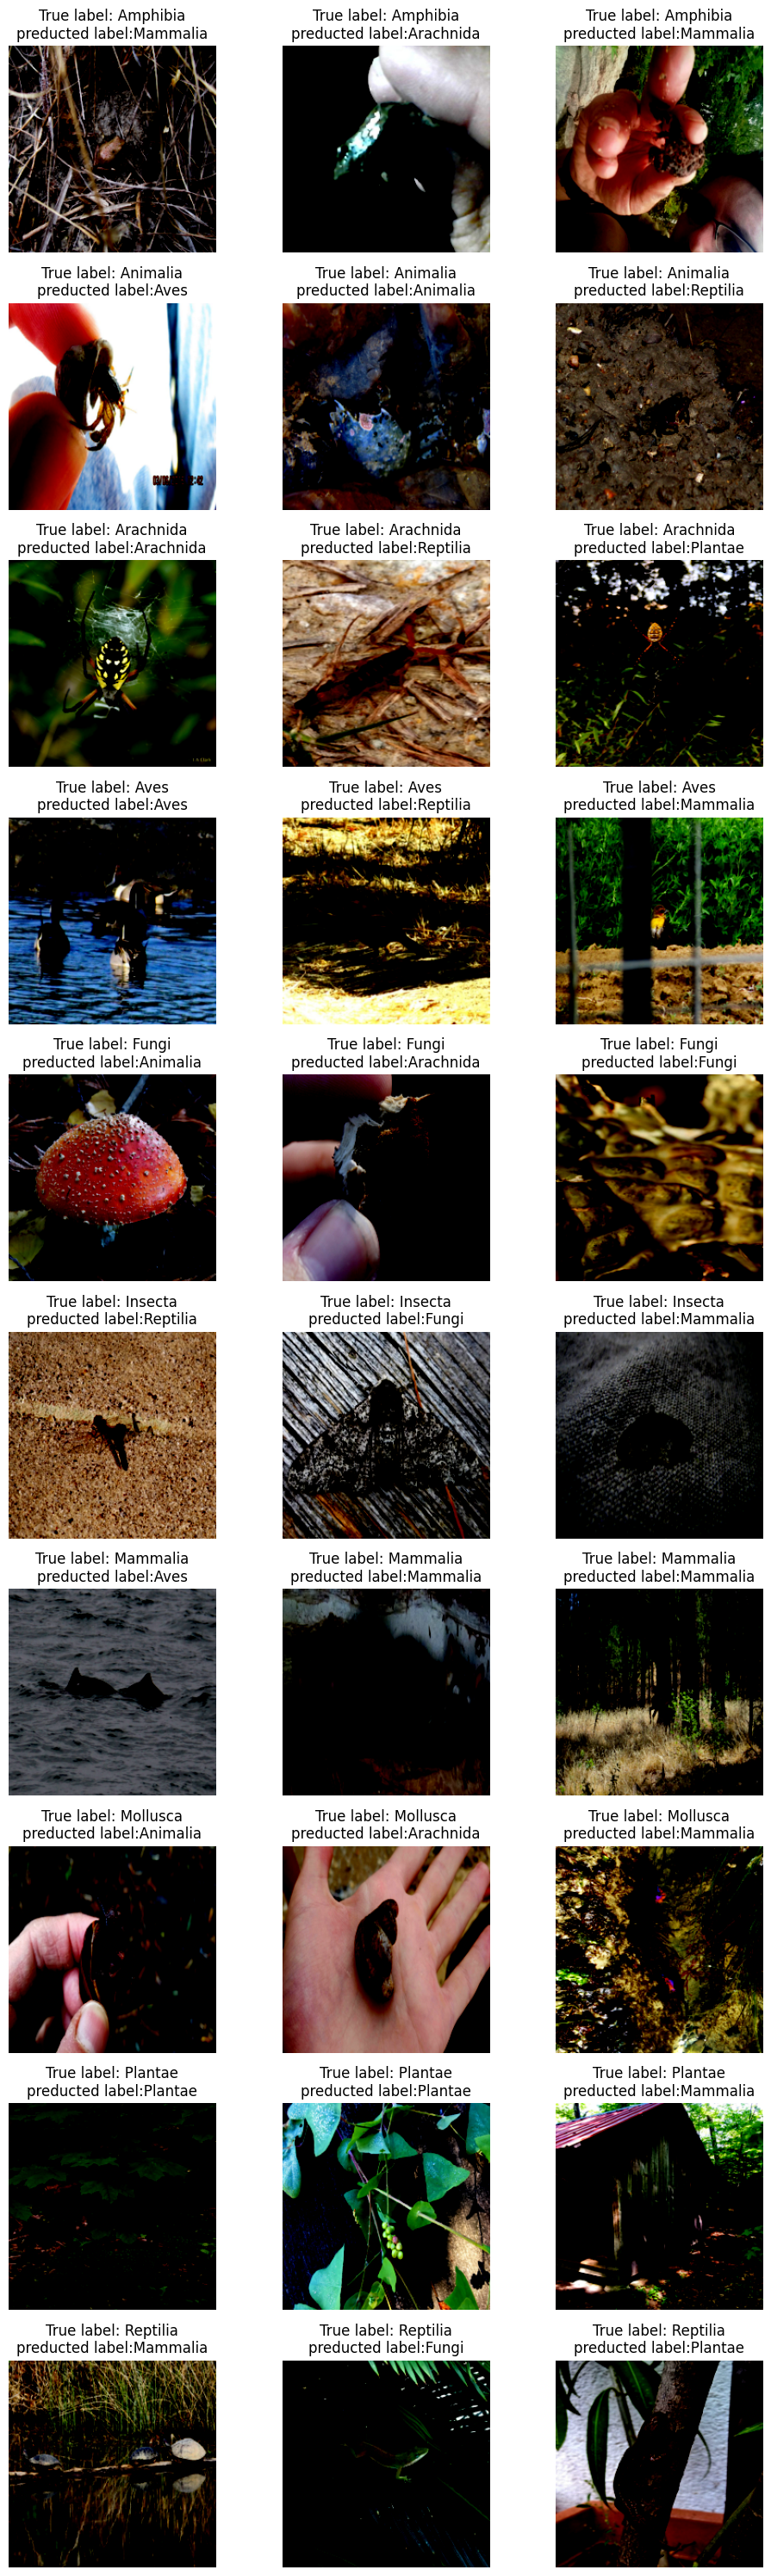

In [90]:
test_path='/nature/inaturalist_12K/val'
root=pathlib.Path(test_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes=(classes[:])
# test_path='/nature/inaturalist_12K/val'
images=[]
labels=[]
predictions=[]
test_data = torchvision.datasets.ImageFolder(test_path, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=2)
num_images_plotted={i: 0 for i in range(10)}
best_model.eval()

fig,axes=plt.subplots(nrows=10,ncols=3,figsize=(10,30))
with torch.no_grad():
  for j,(img,label) in enumerate(test_loader):
    img,label=img.to(device),label.to(device)
    outputs=best_model(img)
    _,predicted=torch.max(outputs.data,1)
    for k in range(img.size(0)):
      true_label=classes[label[k]]
      pred_label=classes[predicted[k]]
      # print(num_images_plotted)
      if num_images_plotted[int(label[k].cpu())]<3:
        image=np.transpose(img[k].cpu().detach().numpy(),(1,2,0))
        axes[int(label[k].cpu()),num_images_plotted[int(label[k].cpu())]].imshow(image)
        axes[int(label[k].cpu()),num_images_plotted[int(label[k].cpu())]].axis('off')
        axes[int(label[k].cpu()),num_images_plotted[int(label[k].cpu())]].set_title('True label: {}\npreducted label:{}'.format(true_label,pred_label))
        num_images_plotted[int(label[k].cpu())]=num_images_plotted[int(label[k].cpu())]+1


    if all(count==3 for count in num_images_plotted.values()):
      break
plt.tight_layout()
plt.show()


In [53]:
print(len(labels))

10


In [ ]:
for k in range(8):

  img=cv2.resize(images[k],(224,224))
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
  
  plt.title('Actual class:'+labels[k]+  "\n" +'Predicted class:'+predictions[k],fontdict={'fontsize':10})
  plt.axis("off")
  plt.tight_layout()
  
  i+=1   